# Baseline Model — Instacart Recommendation

Bu notebook, proje için ilk referans skorunu oluşturmayı hedefler. Buradaki amaç en basit haliyle çalışan bir model kurmak ve ileride yapacağım daha gelişmiş feature engineering adımları için bir başlangıç noktası oluşturmaktır.

**Yaklaşım:**
- Ürün seviyesi temel özellikler (ürünün sipariş edilme sıklığı ve yeniden sipariş oranı)
- Model: Logistic Regression
- Metrik: F1-score (class imbalance: %59 reorder / %41 not reorder)
- Validasyon: Time-based split (geçmiş -->  gelecek tahmini)


Yarışmadaki iyi skor almış çözümleri incelerken çoğunun önce sade bir baseline kurup, asıl ilerlemeyi user–product interaction özellikleriyle sağladığını gördüm. Aynı mantıkla ben de önce küçük ve anlaşılır bir baseline modeli oluşturup, sonraki aşamalarda kullanıcı davranışı ve ürün–kullanıcı ilişkisine yönelik daha güçlü özellikler eklemeyi planlıyorum.


In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

#veri yollarımız
from pathlib import Path
DATA_RAW = Path("../data/raw")
FIGURES = Path("../figures")

print("Kütüphaneler ve yollar hazır.")


Kütüphaneler ve yollar hazır.


hata: PyArrow Deprecation Warning  

çözümü:  

import warnings  
        warnings.filterwarnings("ignore")

In [3]:
orders = pd.read_csv(DATA_RAW / "orders.csv")
products = pd.read_csv(DATA_RAW / "products.csv")
order_products_prior = pd.read_csv(DATA_RAW / "order_products__prior.csv")
order_products_train = pd.read_csv(DATA_RAW / "order_products__train.csv")

print("orders :", orders.shape)
print("products :", products.shape)
print("order_products_prior :", order_products_prior.shape)
print("order_products_train :", order_products_train.shape)

# eval_set kontrolü
print("\nEval set dağılımı:")
print(orders["eval_set"].value_counts())


orders : (3421083, 7)
products : (49688, 4)
order_products_prior : (32434489, 4)
order_products_train : (1384617, 4)

Eval set dağılımı:
eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64


### neden eval_set(her siparişin hangi amaçla kullanıldığını belirten özel kolon) kontrolü yapıyoruz: 

Bunu **EDA defterinde `orders` tablosunu incelerken** görmüştük.  
Orada şu analiz bloklarının içinde yer alıyordu:

- `orders['eval_set'].value_counts()` çıktısı  
- Ayrıca Orders tablosu incelemesinde “prior / train / test” ayrımının ne anlama geldiğini not etmiştik.

Yani; veri setimizde her sipariş bir `eval_set` etiketiyle birlikte gelir.  
Bu kolon, bir siparişin hangi amaçla kullanıldığını belirtir:

- `prior` 'da,  Kullanıcının geçmiş siparişleri 
- `train` 'de, Modelin öğrenmesi gereken siparişler (hedef: reordered)
- `test` 'de Kaggle yarışmasında tahmin etmemiz gereken siparişler

İncelediğim yarışma çözümlerinden anladığım: Bu ayrım Instacart yarışmasının temel mantığıdır:  
Modeli **geçmiş --> gelecek** mantığıyla eğitmek için siparişler üç kategoriye ayrılmıştır.



In [4]:
# 1) Kaç farklı kullanıcı bu ürünü aldı?
prod_user_counts = (
    order_products_prior
    .merge(orders[['order_id', 'user_id']], on='order_id')
    .groupby('product_id')['user_id']
    .nunique()
    .reset_index(name='unique_users')
)

# 2) Ürünün sepette ortalama eklenme sırası
prod_cart_order = (
    order_products_prior
    .groupby('product_id')['add_to_cart_order']
    .mean()
    .reset_index(name='mean_cart_order')
)

# 3) Ürünü tekrar alan kullanıcı oranı
prod_repeat_users = (
    order_products_prior
    .groupby('product_id')['reordered']
    .mean()
    .reset_index(name='repeat_user_rate')
)

# Modelde kullanılacak ürün popülerliği ve tekrar alma oranlarını oluşturma
product_stats = (
    order_products_prior
    .groupby('product_id')
    .agg(
        reorder_sum=('reordered', 'sum'),
        order_count=('reordered', 'count'),
        reorder_ratio=('reordered', 'mean')
    )
    .reset_index()
)

print("Ek ürün özellikleri eklendi.")
print(product_stats.head())


Ek ürün özellikleri eklendi.
   product_id  reorder_sum  order_count  reorder_ratio
0           1         1136         1852       0.613391
1           2           12           90       0.133333
2           3          203          277       0.732852
3           4          147          329       0.446809
4           5            9           15       0.600000


EDA SÜRECİNDE: 
`Orders` + `Products` incelemelerinde gördüklerimiz:  

-En çok satılan ürünler genelde meyve-sebze olduğu (tekrar alınan ürün - süt, muz gibi ürünler)  
-ilk eklenen ürünlerin temel ihtiyaçlar olduğu 
-geç eklenen ürünlerin tamamlayıcı ürünler olduğu

3 maddenin modelleme sürecine katkısı:   

1. Kaç farklı kullanıcı bu ürünü aldığı:  
-Bir ürün çok kullanıcı tarafından tekrar tekrar alınıyorsa bu model için önemli görünüyor  
-ürünün popüleritesini anlamak için önemli bir baseline adımı

2. Ürünün sepette ortalama eklenme sırasını incelemek:  
-ilk eklenen ürünlerin temel ihtiyaçlar olması,geç eklenen ürünlerin tamamlayıcı ürünler olmasından kaynaklı  
-Order_products tablolarında add_to_cart_order sütünunda bunu anlamıştık  
-modelin eğitiminde temel ürünlerin tekrar alınabildiğini öğretmek reorder için kıymetli olur  
-Ürünün alışveriş rutinindeki yeri'ni anlamamızı sağlayacak  

3. Ürünü tekrar alan kullanıcı oranı incelemesi:  
-Order_products_prior tablosunu incelerken farkettiğim genel reorder rate %60 civarındaydı  
-Ratio yüksekse --> sadık kullanıcı kitlesi var  
-Ratio düşükse --> ürünü alan çoğu kişi ikinci kez almamış  
-Ürünün sadakati / tekrar potansiyeli ölçmemizi sağlayacaktır


In [5]:
# Train set için gerekli user_id bilgisini ekliyoruz
train_labels = (
    order_products_train
    .merge(orders[['order_id','user_id']], on='order_id', how='left')
)[['user_id','product_id','reordered']]

# Ürün istatistiklerini train'e bağla
train_data = train_labels.merge(
    product_stats,
    on='product_id',
    how='left'
)

# Eksik değerleri doldur
train_data = train_data.fillna(0)

print(f"Training data: {len(train_data):,} satır")

print("\nÖrnek satırlar:")
print(train_data.head())

print("\nFeature istatistikleri:")
print(train_data[['reorder_ratio','order_count']].describe())


Training data: 1,384,617 satır

Örnek satırlar:
   user_id  product_id  reordered  reorder_sum  order_count  reorder_ratio
0   112108       49302          1        101.0        163.0       0.619632
1   112108       11109          1       3192.0       4472.0       0.713775
2   112108       10246          0      12498.0      23826.0       0.524553
3   112108       49683          0      67313.0      97315.0       0.691702
4   112108       43633          1        312.0        653.0       0.477795

Feature istatistikleri:
       reorder_ratio   order_count
count   1.384617e+06  1.384617e+06
mean    5.789575e-01  3.434516e+04
std     1.533320e-01  7.765599e+04
min     0.000000e+00  0.000000e+00
25%     4.938119e-01  1.425000e+03
50%     6.017316e-01  6.220000e+03
75%     6.884462e-01  2.672100e+04
max     9.411765e-01  4.725650e+05


**1. train_labels' ile:**  

-EDA Sürecinde gördüğümüz: order_products_train tablosunda user_id yoktu  
-modelin doğru öğrenmesi için: kullanıcı–ürün ilişkisi kurması gerekiyo, bu sebeple orders tablosu ile birleştiriyoruz  

**2. product_stats ta ile(reorder_sum,order_count,reorder_ratio):**  

-ürünün kaç kez tekrar alındığını,ürünün toplam kaç kez alındığı, tekrar alma oranı  
-FE için köprü adımları  

**3. önemli gözlemler:**  

user_id = 112108 -- reorder_sum = 101 (sık alınan bir ürün) -- order_count = 163 (ürünün geniş bir kullanıcı kitlesi olduğu görünüyor) --  reorder_ratio = 0.61 (tekrar alınma oranı çok yüksek)  
++  
reorder_ratio //  min: 0 (yeni ürünler) -- max: 94 (süt, yumurta, muz gibi sadık ürünler) -- mean: 0.57 (ürünlerin çoğu tekrar alınıyor gibi)  
++  
order_count // min: 0 (yeni ürünler) -- max: 472k (en çok satın alınan ürünler) 

**ek not:**
Order_products_prior tablosu üzerinden hesapladığımız reorder_ratio özelliğini train_data’ya eklendi  
Bu oran, bir ürünün geçmişte ne kadar tekrar alındığını gösteriyor ve modelin “bu ürün yeniden alınır mı?” sorusunu öğrenmesinde temel sinyal görevi görecek.

In [12]:
X = train_data[['reorder_ratio']]
y = train_data['reordered']

print(y.value_counts(normalize=True).round(3), "\n")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)


reordered
1    0.599
0    0.401
Name: proportion, dtype: float64 



LogisticRegression(max_iter=1000, random_state=42)

**random_state:42 // Hayat, Evren ve Her Şeyin Nihai Cevabı :)**

EDA sürecinde `order_products_prior` tablosunu incelerken:

- `reordered` oranı yaklaşık %60 civarındaydı.
- Yani siparişlerin büyük bölümü tekrar alınan ürünlerden oluşuyor.
- EDA’daki `products_top20.png` grafiğinde de gördüğümüz gibi en çok alınan ürünlerin çoğu taze/sebze/süt ürünleri.  
- Bu yüzden `reorder_ratio` bu ürünlerde doğal olarak yüksek.

Bu bana şunu anlattı:

- Kullanıcılar belirli ürünleri alışkanlık haline getiriyor.
- Modelin asıl öğrenmesi gereken şey: **“Bu ürün tekrar alınır mı?”** sorusu.

Bu soruyu temsil eden özellik **`reorder_ratio`** olduğu için ilk modelde sadece bu feature ile ilerliyorum.


Baseline model performansı

F1-Score :  0.7452
Precision: 0.6614
Recall   : 0.8535



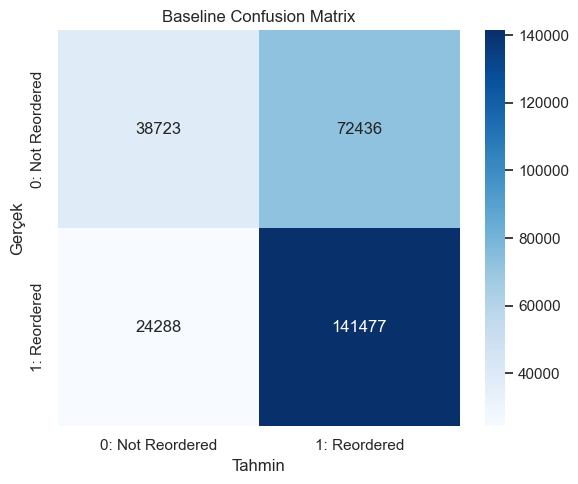

Confusion matrix kaydedildi → figures/baseline_confusion_matrix.png


In [9]:
# Tahminler
y_pred = model.predict(X_val)

print("Baseline model performansı\n")

# Temel metrikler
f1 = f1_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

print(f"F1-Score :  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['0: Not Reordered', '1: Reordered'],
    yticklabels=['0: Not Reordered', '1: Reordered']
)
plt.title("Baseline Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.savefig(FIGURES / "baseline_confusion_matrix.png", dpi=300)
plt.show()

print("Confusion matrix kaydedildi → figures/baseline_confusion_matrix.png")

Tahminlerim üzerine  `reorder_ratio` featuresi çok güçlü.

tek featureye rağmen güçlü bi baseline oldu:   

-F1: 0.7452 tek feature ile iyi bir skor  
-Recall: %85 model tekrar alınacak ürünleri güçlü şekilde anlıyor  
-Precision: 0.66 38723 doğru tahmin - 72.436 yanlış tahmin yapmış, tek feature ile iyi ama FE İle daha iyi tahminler yapabilecek  

Data Leakage var mı FE aşamasında tekrar bakılmalı.  
Train/test split'i doğrulanacak.  

detaylı incele  baseline_report.md dosyasında.  
